In [1]:
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import VotingRegressor
import numpy as np
import pandas as pd
import tensorflow as tf

from imbd.trainers import ModelTrainer
from imbd.data import DataLoader
from imbd.preprocessors import DataPreprocessor
from imbd.models import KerasModel

In [2]:
loader = DataLoader()
prepro = DataPreprocessor()


In [3]:
# initialization
loader = DataLoader()
preprocessor = DataPreprocessor()
df = loader.build()

# get feature & label
train_features = df.drop(loader.labels, axis=1)
train_labels = df[loader.labels]

In [4]:
# base_model = MultiOutputRegressor(XGBRegressor())
# base_model = MultiOutputRegressor(VotingRegressor([('xgb', XGBRegressor()), ('xgb_rf', XGBRFRegressor())]))
order = [0, 2, 5, 7, 13, 14, 16, 17] + [1, 3, 4, 6, 8, 9, 11, 12, 15, 18, 19] + [10]
base_model = RegressorChain(VotingRegressor([('xgb', XGBRegressor()), ('xgb_rf', XGBRFRegressor())]), order=order)
# base_model = RegressorChain(XGBRFRegressor(), order=order)

# base_nn_model = KerasRegressor(build_fn=classifier, epochs=100)
base_nn_model = KerasModel()

In [5]:

param_grid = {
    "prepro__variance_selector__threshold": [0.0, 0.01],
    # "voting__estimator__xgb__subsample": [1, 0.5],
    # "voting__estimator__xgb__max_depth": [2, 6],
    # "voting__estimator__xgb_rf__max_depth": [2, 6],
    # "voting__estimator__xgb_rf__subsample": [1, 0.5],
    "voting__base_estimator__weights": [[0.5, 0.5], [0.4, 0.6]],
    "voting__base_estimator__xgb__n_estimators": [1000],
    "voting__base_estimator__xgb_rf__n_estimators": [1000],
}

In [6]:
# build pipeline
steps = [('prepro', preprocessor), ('voting', base_model)]
pipe = Pipeline(steps=steps)

In [7]:
pipe.get_params()['voting']

RegressorChain(base_estimator=VotingRegressor(estimators=[('xgb',
                                                           XGBRegressor(base_score=None,
                                                                        booster=None,
                                                                        colsample_bylevel=None,
                                                                        colsample_bynode=None,
                                                                        colsample_bytree=None,
                                                                        gamma=None,
                                                                        gpu_id=None,
                                                                        importance_type='gain',
                                                                        interaction_constraints=None,
                                                                        learning_rate=None,
              

In [8]:
# training
trainer = ModelTrainer(pipe=pipe, param_grid=param_grid, verbose=2)
# fitted = trainer.fit(train_features, train_labels)
fitted = trainer.fit(train_features, train_labels)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] prepro__variance_selector__threshold=0.0, voting__base_estimator__weights=[0.5, 0.5], voting__base_estimator__xgb__n_estimators=1000, voting__base_estimator__xgb_rf__n_estimators=1000 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  prepro__variance_selector__threshold=0.0, voting__base_estimator__weights=[0.5, 0.5], voting__base_estimator__xgb__n_estimators=1000, voting__base_estimator__xgb_rf__n_estimators=1000, total= 1.4min
[CV] prepro__variance_selector__threshold=0.0, voting__base_estimator__weights=[0.5, 0.5], voting__base_estimator__xgb__n_estimators=1000, voting__base_estimator__xgb_rf__n_estimators=1000 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[CV]  prepro__variance_selector__threshold=0.0, voting__base_estimator__weights=[0.5, 0.5], voting__base_estimator__xgb__n_estimators=1000, voting__base_estimator__xgb_rf__n_estimators=1000, tot

In [9]:
fitted.best_score_

-0.1291654184234396

In [10]:
pd.DataFrame(fitted.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_prepro__variance_selector__threshold,param_voting__base_estimator__weights,param_voting__base_estimator__xgb__n_estimators,param_voting__base_estimator__xgb_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,84.236039,15.214499,0.925438,0.041956,0,"[0.5, 0.5]",1000,1000,"{'prepro__variance_selector__threshold': 0.0, ...",-0.142777,-0.161587,-0.083931,-0.129432,0.033078,2,-0.018493,-0.016151,-0.030638,-0.021761,0.006350
1,81.998784,5.574311,0.956889,0.083691,0,"[0.4, 0.6]",1000,1000,"{'prepro__variance_selector__threshold': 0.0, ...",-0.142370,-0.161884,-0.083242,-0.129165,0.033435,1,-0.022111,-0.019339,-0.032634,-0.024695,0.005727
2,56.020515,4.122993,1.067365,0.287151,0.01,"[0.5, 0.5]",1000,1000,"{'prepro__variance_selector__threshold': 0.01,...",-0.146407,-0.163988,-0.089348,-0.133248,0.031861,4,-0.026782,-0.030336,-0.036565,-0.031228,0.004043
3,45.461878,3.314260,0.990178,0.097739,0.01,"[0.4, 0.6]",1000,1000,"{'prepro__variance_selector__threshold': 0.01,...",-0.143505,-0.162932,-0.089221,-0.131886,0.031194,3,-0.041120,-0.032875,-0.040899,-0.038298,0.003836


In [11]:
pred = fitted.predict(train_features)
pred = pd.DataFrame(pred, columns=train_labels.columns)

res = np.abs(pred - train_labels)
res = res.rename(mapper=lambda x: x + "_diff", axis=1)
res['mean'] = np.mean(res, axis=1)
res['label'] = pd.cut(res['mean'].astype('category'), bins=3, labels=['0', '1', '2'])
res['label'] = res['label'].astype(int)

In [12]:
res

,Input_A6_024_diff,Input_A3_016_diff,Input_C_013_diff,Input_A2_016_diff,Input_A3_017_diff,Input_C_050_diff,Input_A6_001_diff,Input_C_096_diff,Input_A3_018_diff,Input_A6_019_diff,...,Input_A3_015_diff,Input_C_046_diff,Input_C_049_diff,Input_A2_024_diff,Input_C_058_diff,Input_C_057_diff,Input_A3_013_diff,Input_A2_017_diff,mean,label
0,0.000335,0.003483,0.000232,0.001369,0.000053,0.000914,0.000330,0.003322,0.004770,0.004788,...,0.010141,0.000059,0.000115,0.000068,0.001256,0.000835,0.000298,0.003064,0.003926,0
1,0.000046,0.000456,0.000526,0.001856,0.004085,0.000331,0.000002,0.004708,0.003610,0.000262,...,0.008320,0.000087,0.000024,0.000005,0.000607,0.000891,0.000044,0.000750,0.003379,0
2,0.000017,0.001444,0.000284,0.001890,0.003160,0.000437,0.000002,0.001019,0.002557,0.002494,...,0.007620,0.000051,0.000094,0.000071,0.000070,0.001286,0.000057,0.002557,0.002179,0
3,0.000098,0.005265,0.000505,0.005139,0.004895,0.000193,0.000106,0.002494,0.004227,0.004500,...,0.000196,0.000454,0.000376,0.000140,0.000407,0.000352,0.000682,0.002314,0.003169,0
4,0.000100,0.003481,0.000439,0.002662,0.002243,0.000543,0.000034,0.000271,0.002255,0.003607,...,0.005335,0.000091,0.000071,0.000143,0.000457,0.001641,0.001566,0.002199,0.004665,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.000084,0.000253,0.000192,0.002269,0.000084,0.000112,0.000002,0.000494,0.003881,0.000290,...,0.006794,0.000022,0.000079,0.001235,0.000097,0.000139,0.000204,0.000474,0.002042,0
335,0.001087,0.005673,0.000219,0.000836,0.000555,0.000049,0.000036,0.000342,0.004083,0.001713,...,0.005819,0.000427,0.000327,0.000293,0.000049,0.000419,0.000461,0.001576,0.003701,0
336,0.000117,0.001043,0.000190,0.000768,0.004347,0.000002,0.000002,0.000747,0.000019,0.000824,...,0.000523,0.000566,0.000015,0.000011,0.000299,0.000439,0.001237,0.002903,0.001957,0
337,0.000018,0.000870,0.000266,0.002257,0.005303,0.000118,0.000002,0.000333,0.004598,0.003867,...,0.004498,0.000123,0.000393,0.000003,0.000053,0.000147,0.000517,0.000907,0.002819,0


In [13]:
import plotly.express as px

In [14]:
res.filter(regex='Input_A[0-9]*_[0-9]+').columns

Index(['Input_A6_024_diff', 'Input_A3_016_diff', 'Input_A2_016_diff',
       'Input_A3_017_diff', 'Input_A6_001_diff', 'Input_A3_018_diff',
       'Input_A6_019_diff', 'Input_A1_020_diff', 'Input_A6_011_diff',
       'Input_A3_015_diff', 'Input_A2_024_diff', 'Input_A3_013_diff',
       'Input_A2_017_diff'],
      dtype='object')

In [15]:
train_labels.columns

Index(['Input_A6_024', 'Input_A3_016', 'Input_C_013', 'Input_A2_016',
       'Input_A3_017', 'Input_C_050', 'Input_A6_001', 'Input_C_096',
       'Input_A3_018', 'Input_A6_019', 'Input_A1_020', 'Input_A6_011',
       'Input_A3_015', 'Input_C_046', 'Input_C_049', 'Input_A2_024',
       'Input_C_058', 'Input_C_057', 'Input_A3_013', 'Input_A2_017'],
      dtype='object')

In [16]:
feature_cols = list(train_features.filter(regex='Input_A[0-9]_020').columns)
diff_cols = list(res.filter(regex='Input_A1_[0-9]+_diff').columns[:5])

fig = px.parallel_coordinates(pd.concat([train_features, res], axis=1), feature_cols + diff_cols + ['label'] , color='label')
fig.update_layout(width=1600, height=800)
fig.show()

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

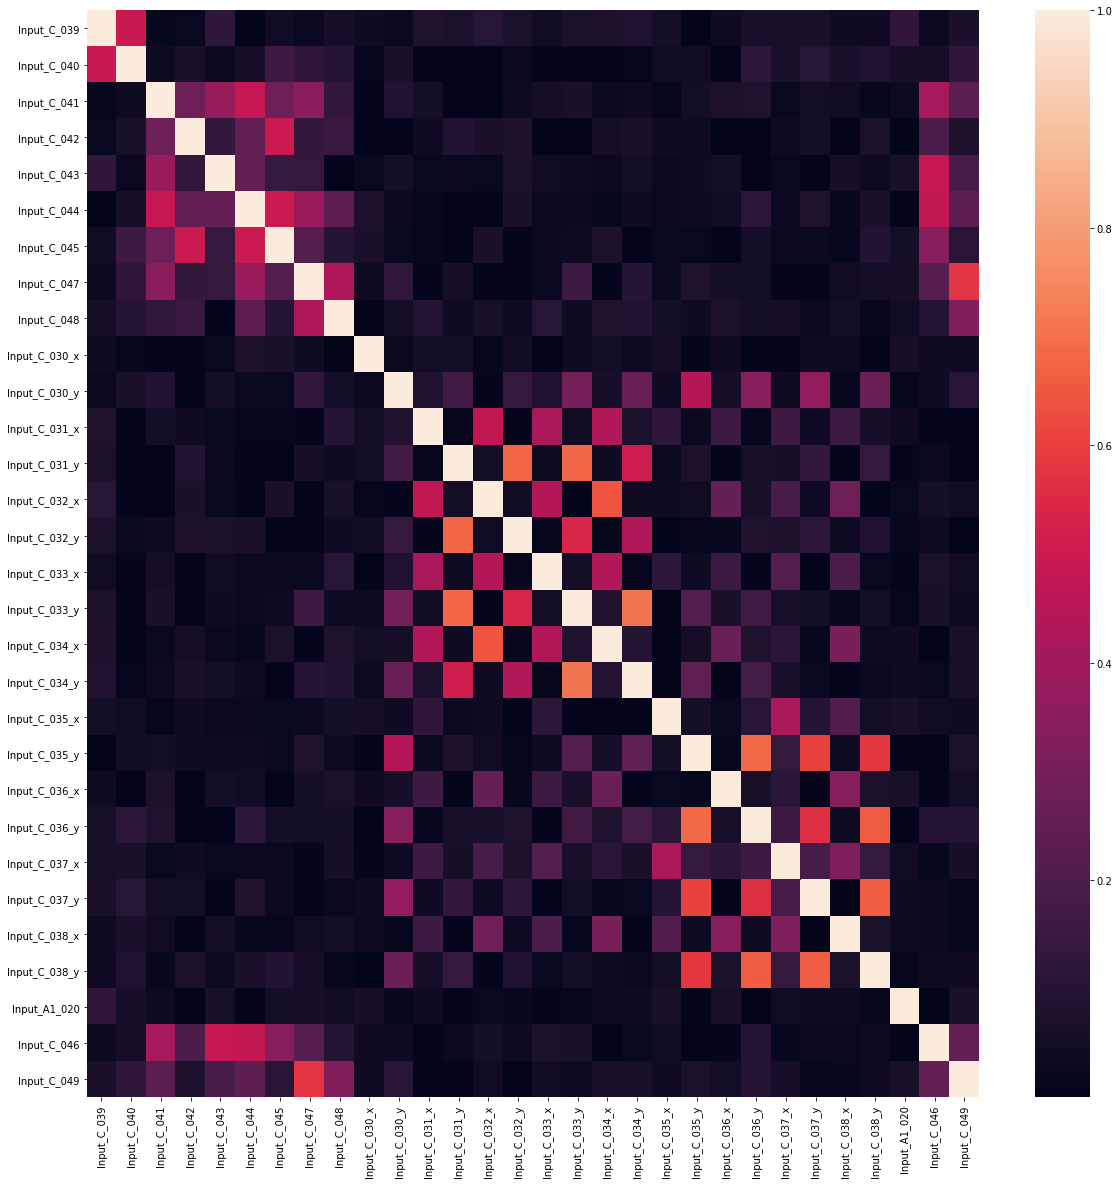

In [18]:
fig_, ax = plt.subplots(figsize=(20, 20))
test = pd.concat([train_features,train_labels], axis=1)
sns.heatmap(np.abs(test.filter(regex='(Input_C_0[3-4][0-9]|Input_A1_020)').corr()))

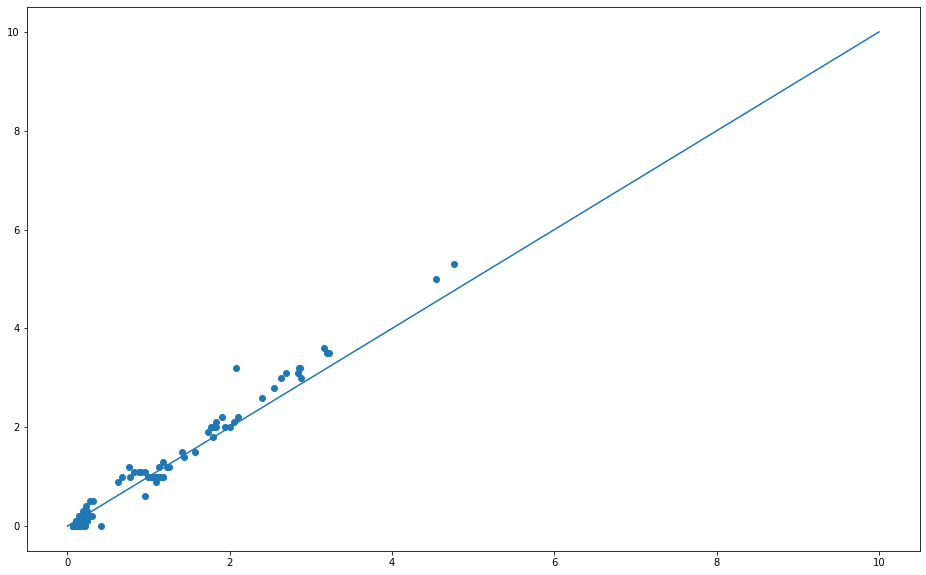

In [19]:
fig, ax = plt.subplots(figsize=(16, 10))
test = pd.concat([pred['Input_A1_020'], train_labels['Input_A1_020']], axis=1)

plt.scatter(test.values[:,0], test.values[:, 1])
x = np.linspace(0, 10, 10)
plt.plot(x, x)


In [20]:
np.sqrt(np.mean((test.iloc[:, 0] - test.iloc[:, 1]) ** 2))

0.12630781524154766

In [21]:
fitted.best_score_

-0.1291654184234396

In [22]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.decomposition import PCA

In [23]:
km = KMeans(3)
tsne = PCA()

In [24]:
cl = km.fit_predict(train_features.dropna().filter(regex='Input_A[0-9]_020'))

In [25]:
cl

array([1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [26]:
test = tsne.fit_transform(train_features.dropna().filter(regex='Input_A[0-9]_020'))

In [27]:
import plotly.graph_objects as go

go.Figure(data=go.Scatter(x=test[:, 0], y=test[:, 1], mode='markers', marker_color=cl, marker_size=train_labels.dropna()['Input_A1_020']*5, text=train_labels.dropna()['Input_A1_020']))